In [2]:
!pip install rebound
!pip install spock
from spock import FeatureClassifier
fmodel = FeatureClassifier()

from spock import NbodyRegressor
nbody = NbodyRegressor()

from spock import DeepRegressor
dmodel = DeepRegressor()

  Using cached rebound-3.20.0.tar.gz (281 kB)
  Created wheel for rebound: filename=rebound-3.20.0-cp39-cp39-linux_x86_64.whl size=312411 sha256=1e6576cc0c4e10383715a3bf1d852ff31c10178efea5f5728f342c4a3bf45078
  Stored in directory: /mnt/ssd/home/bbonifacio/.cache/pip/wheels/a4/52/1c/a62d92c22bf4bc64111a9744b6aad36efd756e17b1f779b5dc
Successfully built rebound


In [1]:
#Variables to play with:


bin_number = 30

In [2]:
from __future__ import print_function
import numpy as np
from warnings import filterwarnings
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import lognorm
import math
import rebound
%matplotlib inline
import random
import matplotlib.pyplot as plt
from spock import FeatureClassifier
import scipy
from decimal import Decimal
import pandas as pd
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import seed, random
from scipy.stats import rayleigh
from scipy.stats import norm
#from spock import FeatureClassifier
import itertools


fmodel = FeatureClassifier()

earth_mass = 5.97219*10**24
sun_mass = 1.981 * 10**30
mass_ratio = earth_mass/sun_mass


/mnt/ssd/home/bbonifacio/anaconda3/envs/bbonifacio/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


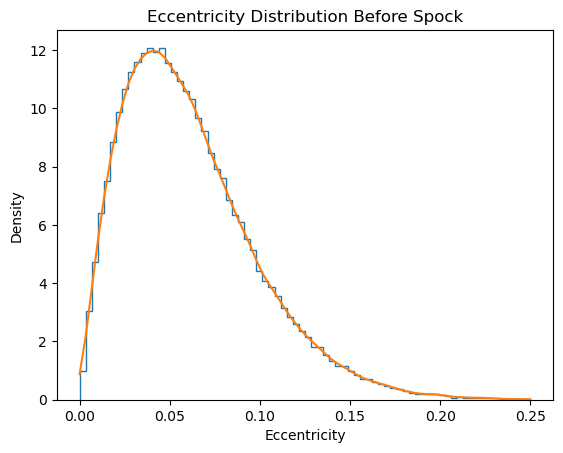

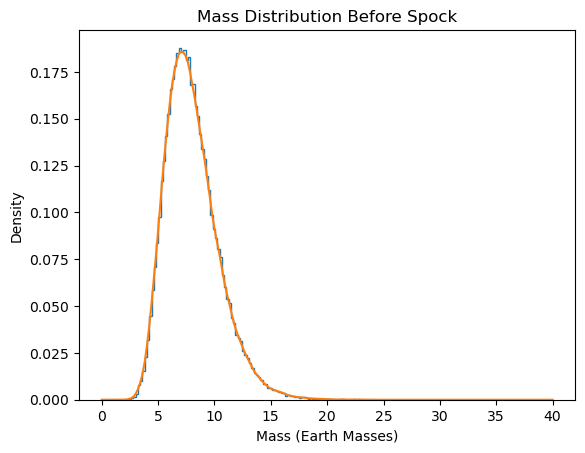

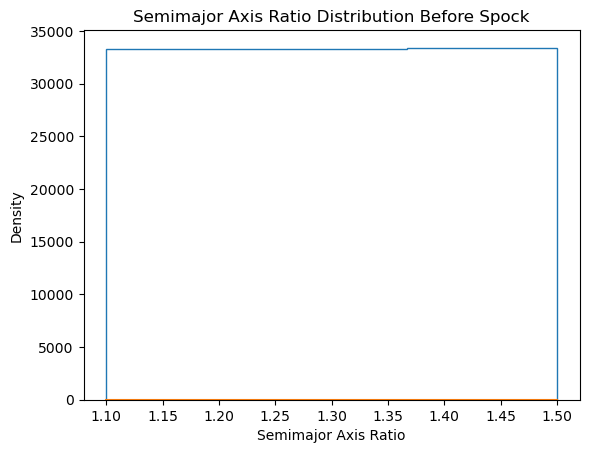

In [3]:
"""

Initialize the original population

"""

num_iter =100000     #settings["monte_carlo"]["num_iter"]
#0.049
e_mean = 0.049#0.02632     #settings["planetary_system"]["mean_e"]
e_error=  0.013     #settings["planetary_system"]["e_error"]
m_mean =  7.7         #Wu 2019 Mass and Mass Scalings of Super Earths 
m_error =  0.29    #settings["planetary_system"]["m_error"]
#Distribution of period ratios is uniform
a_min = 1.1
a_max = 1.5

e_list = []
a_list = []
m_list = lognorm.rvs(s=m_error, scale=m_mean, size=num_iter) #math.exp(8)

for m in m_list:
    if m < 0:
        m_list.remove(m)
        


for i in range(num_iter):
    #Generate e using Rayleigh Distribution
    #e_mu = np.random.normal(e_mean)

    #Generate a_ratio
    a = np.random.uniform(a_min,a_max)
    a_list.append(a)

    
while len(e_list) < num_iter:
    scale = np.random.normal(e_mean, e_error)
    if scale < 0:
        scale = 0
    e = np.random.rayleigh(scale = scale)
    if not (e < 0 or e > 1):
        e_list.append(e)
    


density = stats.gaussian_kde(e_list)
n, x, _ = plt.hist(e_list, bins=np.linspace(0, 0.25, 75),
                   histtype=u'step', density=True)  
plt.plot(x, density(x))

plt.title("Eccentricity Distribution Before Spock")
plt.xlabel("Eccentricity")
plt.ylabel("Density")
plt.show()


density = stats.gaussian_kde(m_list)
n, x, _ = plt.hist(m_list,  bins=np.linspace(0, 40, 200),
                   histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.title("Mass Distribution Before Spock")
plt.xlabel("Mass (Earth Masses)")
plt.ylabel("Density")
#plt.xscale("log")
plt.show()


n, x, _ = plt.hist(a_list, bins=np.linspace(1.1,1.5, 4),
                   histtype=u'step', density = False)
plt.plot(x, density(x))
plt.title("Semimajor Axis Ratio Distribution Before Spock")
plt.xlabel("Semimajor Axis Ratio")
plt.ylabel("Density")
plt.show()





In [4]:
#This only needs to be run once
spock_e_list = []
spock_a_list = []
spock_m_list = []
a_weight_array = []
triple_weight_array = []
p_list = []
iter_list = []

In [5]:
#LOADS OBSERVATIONAL DATA

pairs = pd.read_csv('exoarchive_planet_pairs.csv', index_col=0)
res2 = np.load('res.npy', allow_pickle=True)

bins=np.linspace(1.1, 1.51, bin_number) ##!!!!!
mask = pairs['Pratio'] < 1.5

#observed_period_ratio_complete_list = pairs['Pratio'][mask]

count, edges = np.histogram(pairs['Pratio'][mask], bins=bins)

values = count

pdf = count/sum(count)
observed_norm_cumulative = np.cumsum(pdf)

observed_period_pdf = count
observed_period_cdf = observed_norm_cumulative


In [6]:
"""
Run Program

"""

print("Program Started")


for j in range(20):
    print(str(j))
    sim_list = []
    for index in range(20):
        i = int(np.random.uniform(0,10000))
        temp_e1 = e_list[3*i]
        temp_e2 = e_list[3*i+1]
        temp_e3 = e_list[3*i+2]

        temp_m1 = m_list[3*i] 
        temp_m2 = m_list[3*i+1] 
        temp_m3 = m_list[3*i+2] 

        temp_a1 = a_list[int(np.random.uniform(0,num_iter))]
        temp_a2 = a_list[int(np.random.uniform(0,num_iter))]

        temp_sim = rebound.Simulation()
        temp_sim.add(m=1) #or 1.1
        #Period ratio squared 
        #20% probability is 20% of total
        #Give it an array with a weight array
        temp_sim.add(m=temp_m1*mass_ratio, P = 1, e = temp_e1)
        temp_sim.add(m=temp_m2*mass_ratio, P = temp_a1, e = temp_e2)
        temp_sim.add(m=temp_m3*mass_ratio, P = temp_a1*temp_a2, e = temp_e3)

        spock_e_list.append(temp_e1)
        spock_e_list.append(temp_e2)
        spock_e_list.append(temp_e3)
        spock_m_list.append(temp_m1)
        spock_m_list.append(temp_m2)
        spock_m_list.append(temp_m3)
        spock_a_list.append(temp_a1)
        spock_a_list.append(temp_a2)

        sim_list.append(temp_sim)

    temp_a_weight_array = fmodel.predict_stable(sim_list)
    temp_triple_weight_array = np.repeat(temp_a_weight_array, 3)
    temp_a_weight_array = np.repeat(temp_a_weight_array,2)
    a_weight_array = np.concatenate([a_weight_array, temp_a_weight_array])
    triple_weight_array = np.concatenate([triple_weight_array, temp_triple_weight_array])


    #Bin Size is Very important!
    spock_p_values, spock_p_base = np.histogram(spock_a_list , weights = a_weight_array, bins=np.linspace(1.1, 1.51, bin_number))
    spock_p_cumsum = np.cumsum(spock_p_values)/max(np.cumsum(spock_p_values))

    #Here we calculate the p value and add it to our p_list

    ksprob = scipy.stats.kstest(spock_p_cumsum, observed_period_cdf, args = (), alternative = 'two-sided',
                                method = 'exact')

    
    pvalue = ksprob[1]
    p_list.append(pvalue)
    iter_list.append(len(spock_a_list))

print("done")

Program Started
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done


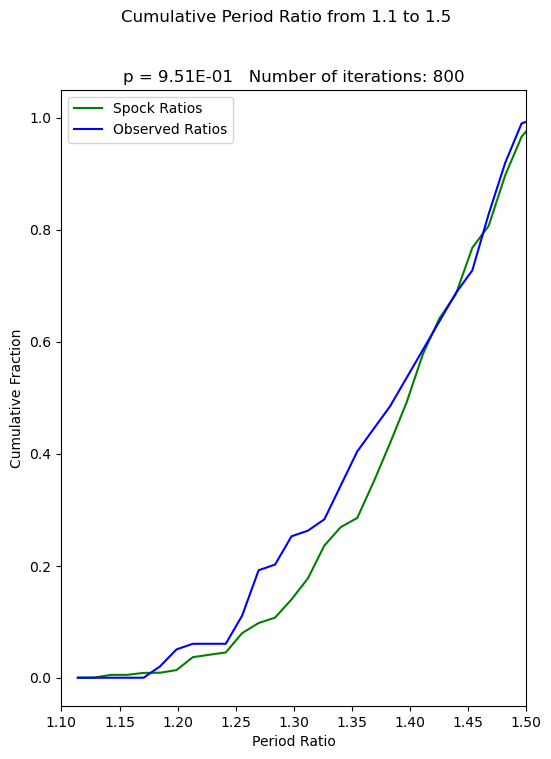

<Figure size 1000x100 with 0 Axes>

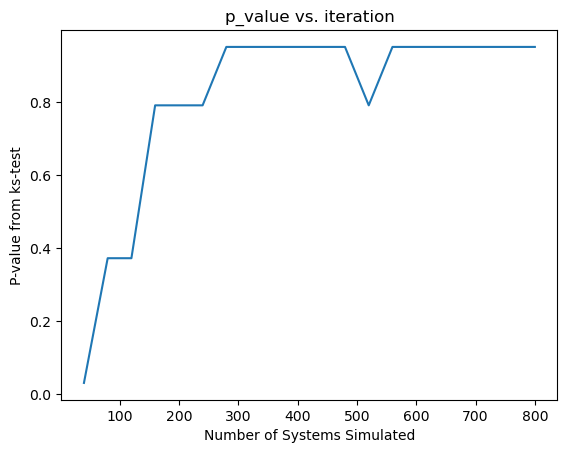

In [7]:
#Below plots the cdf

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(6)

plt.plot(edges[1:], spock_p_cumsum, c = 'green')
plt.plot(edges[1:], observed_period_cdf, c = 'blue')
plt.legend(["Spock Ratios", "Observed Ratios"])
plt.suptitle("Cumulative Period Ratio from 1.1 to 1.5")
plt.title("p = " + '%.2E' % Decimal( str(p_list[-1])  ) + "   Number of iterations: " + str(len(spock_a_list)))
plt.xlabel("Period Ratio")
plt.ylabel("Cumulative Fraction")
plt.xlim(1.1,1.5)
plt.figure(figsize=(10, 1))
plt.show()


plt.plot(iter_list,p_list)
plt.title("p_value vs. iteration")
plt.xlabel("Number of Systems Simulated")
plt.ylabel("P-value from ks-test")
plt.show()









In [ ]:



#OLD STUFF BELOW
















#Below are old plots
"""
density = stats.gaussian_kde(spock_e_list, weights = triple_weight_array)
n, x, _ = plt.hist(spock_e_list, bins=np.linspace(0, 0.25, 20), weights = triple_weight_array,
                   histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.title("Eccentricity Distribution After Spock")
plt.xlabel("Eccentricity")
plt.ylabel("Density")
plt.show()


density = stats.gaussian_kde(spock_m_list, weights = triple_weight_array)
n, x, _ = plt.hist(spock_m_list,bins=np.linspace(0, 40, 20), weights = triple_weight_array,
                   histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.title("Mass Distribution After Spock")
plt.xlabel("Mass (Earth Masses)")
plt.ylabel("Density")
plt.show()

 
density = stats.gaussian_kde(spock_a_list, weights = a_weight_array)
n, x, _ = plt.hist(spock_a_list, bins=np.linspace(1.1, 1.5, 20), weights = a_weight_array,
                   histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.title("Period Ratio Distribution After Spock Filtering")
plt.xlabel("Period Ratio")
plt.ylabel("Density")
plt.show()
"""






"""
observed_a_list = []
for i in range(100000):
    temp = np.random.normal(1.39,0.1)
    if ((temp > 1.1) and (temp < 1.5)):
        observed_a_list.append(temp)
values, base = np.histogram(observed_a_list, bins=np.linspace(1.1, 1.5, 50))
cumulative = np.cumsum(values)
observed_norm_cumulative = cumulative/max(cumulative)


values, base = np.histogram(spock_a_list , weights = a_weight_array, bins=np.linspace(1.1, 1.51, 50))

cumulative = np.cumsum(values)
spock_norm_cumulative = cumulative/max(cumulative)

observed_a_list = []
for i in range(100000):
    temp = np.random.normal(1.39,0.1)
    if ((temp > 1.1) and (temp < 1.5)):
        observed_a_list.append(temp)
values, base = np.histogram(observed_a_list, bins=np.linspace(1.1, 1.5, 50))
cumulative = np.cumsum(values)
observed_norm_cumulative = cumulative/max(cumulative)

"""





























































































"""
density = stats.gaussian_kde(spock_e_list, weights = triple_weight_array)
n, x, _ = plt.hist(spock_e_list, bins=np.linspace(0, 0.25, 20), weights = triple_weight_array,
                   histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.title("Eccentricity Distribution After Spock")
plt.xlabel("Eccentricity")
plt.ylabel("Density")
plt.show()


density = stats.gaussian_kde(spock_m_list, weights = triple_weight_array)
n, x, _ = plt.hist(spock_m_list,bins=np.linspace(0, 40, 20), weights = triple_weight_array,
                   histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.title("Mass Distribution After Spock")
plt.xlabel("Mass (Earth Masses)")
plt.ylabel("Density")
plt.show()

 
density = stats.gaussian_kde(spock_a_list, weights = a_weight_array)
n, x, _ = plt.hist(spock_a_list, bins=np.linspace(1.1, 1.5, 20), weights = a_weight_array,
                   histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.title("Semimajor Axis Ratio Distribution After Spock")
plt.xlabel("Semimajor Axis Ratio")
plt.ylabel("Density")
plt.show()
"""

#Below Plots the PDF function
"""

fig = plt.figure()

fig.set_figheight(5)
fig.set_figwidth(5)

density = stats.gaussian_kde(spock_a_list,weights = a_weight_array)
n, x, _ = plt.hist(spock_a_list, bins=np.linspace(1.1, 1.5, 15), weights = a_weight_array,
                   histtype=u'step', density=True)  
plt.plot(x, density(x))

density = stats.gaussian_kde(observed_a_list)
n, x, _ = plt.hist(observed_a_list, bins=np.linspace(1.1, 1.5, 15),
                   histtype=u'step', density=True) 
plt.plot(x, density(x))

plt.legend(["Spock Histogram", "Spock KDE","Observed Histogram", "Observed KDE"],loc = 'upper left')


plt.suptitle("KDEs for Semimajor Axis Ratios")
plt.title("p = " + '%.2E' % Decimal( str(pvalue)  ))
plt.xlabel("Semimajor Axis Ratio")
plt.ylabel("Weighted Count")

plt.show()

plt.plot(iter_list, p_list)
plt.title("P value vs. iteration")
plt.show()
"""


































































































































































































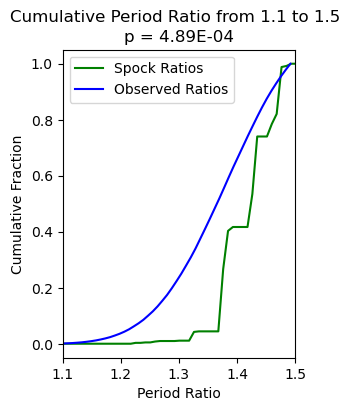

<Figure size 1000x100 with 0 Axes>

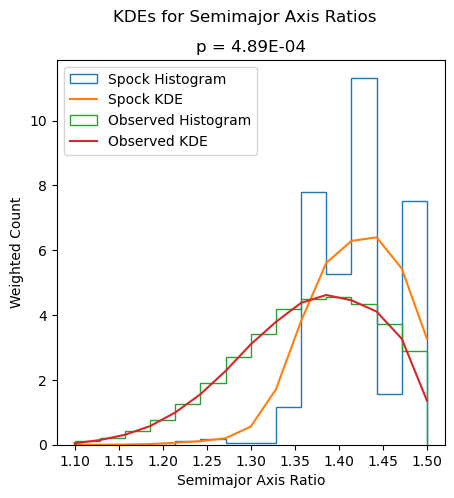

This is performed with 30 Spock Data Points.


In [36]:








ksprob = scipy.stats.kstest(spock_norm_cumulative, observed_norm_cumulative, args = (), alternative = 'two-sided', 
                           method = 'exact')

pvalue = ksprob[1]

#Filtering Data

                  
                       
values, base = np.histogram(spock_a_list , weights = a_weight_array, bins=np.linspace(1.1, 1.51, 50))

cumulative = np.cumsum(values)
norm_cumulative = cumulative/max(cumulative)






fig = plt.figure()

fig.set_figheight(4)
fig.set_figwidth(3)

plt.plot(base[:-1], norm_cumulative, c = 'green')


observed_a_list = []
for i in range(100000):
    temp = np.random.normal(1.39,0.1)
    if ((temp > 1.1) and (temp < 1.5)):
        observed_a_list.append(temp)

        
values, base = np.histogram(observed_a_list, bins=np.linspace(1.1, 1.5, 50))

cumulative = np.cumsum(values)
norm_cumulative = cumulative/max(cumulative)

plt.plot(base[:-1], norm_cumulative, c = 'blue')
plt.legend(["Spock Ratios", "Observed Ratios"])

plt.suptitle("Cumulative Period Ratio from 1.1 to 1.5")
plt.title("p = " + '%.2E' % Decimal( str(pvalue)  ))
plt.xlabel("Period Ratio")
plt.ylabel("Cumulative Fraction")
plt.xlim(1.1,1.5)
plt.figure(figsize=(10, 1))
plt.show()
        

        
fig = plt.figure()

fig.set_figheight(5)
fig.set_figwidth(5)

density = stats.gaussian_kde(spock_a_list,weights = a_weight_array)
n, x, _ = plt.hist(spock_a_list, bins=np.linspace(1.1, 1.5, 15), weights = a_weight_array,
                   histtype=u'step', density=True)  
plt.plot(x, density(x))

density = stats.gaussian_kde(observed_a_list)
n, x, _ = plt.hist(observed_a_list, bins=np.linspace(1.1, 1.5, 15),
                   histtype=u'step', density=True) 
plt.plot(x, density(x))

plt.legend(["Spock Histogram", "Spock KDE","Observed Histogram", "Observed KDE"],loc = 'upper left')




plt.suptitle("KDEs for Semimajor Axis Ratios")
plt.title("p = " + '%.2E' % Decimal( str(pvalue)  ))
plt.xlabel("Semimajor Axis Ratio")
plt.ylabel("Weighted Count")
plt.show()


print("This is performed with " + str(len(spock_a_list)) + " Spock Data Points." )




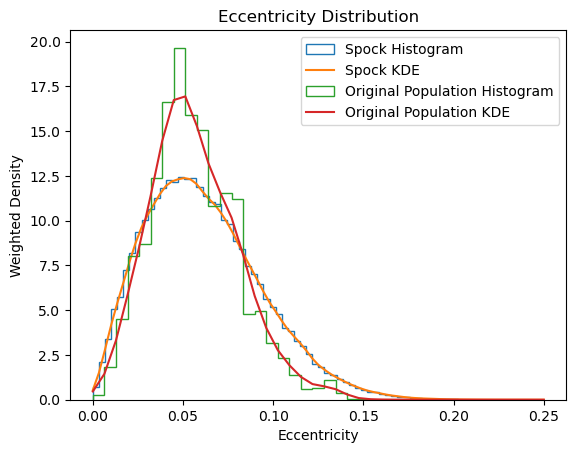

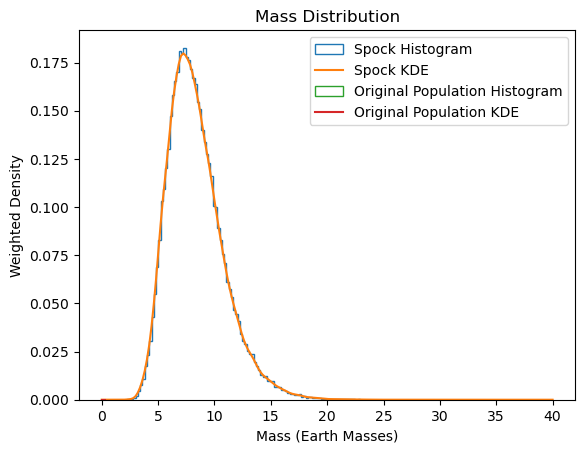

In [153]:



density = stats.gaussian_kde(e_list)
n, x, _ = plt.hist(e_list, bins=np.linspace(0, 0.25, 75),
                   histtype=u'step', density=True)  
plt.plot(x, density(x))


density = stats.gaussian_kde(spock_e_list, weights = triple_weight_array)
n, x, _ = plt.hist(spock_e_list, bins=np.linspace(0, 0.25, 40),
                   histtype=u'step', density=True, weights = triple_weight_array)  
plt.plot(x, density(x))


plt.title("Eccentricity Distribution")
plt.xlabel("Eccentricity")
plt.ylabel("Weighted Density")

plt.legend(["Spock Histogram", "Spock KDE","Original Population Histogram", "Original Population KDE"],loc = 'upper right')

plt.show()


density = stats.gaussian_kde(m_list)
n, x, _ = plt.hist(m_list,  bins=np.linspace(0, 40, 200),
                   histtype=u'step', density=True)  
plt.plot(x, density(x))

density = stats.gaussian_kde(spock_m_list, weights = triple_weight_array)
n, x, _ = plt.hist(spock_m_list, bins=np.linspace(0, 0.25, 75),
                   histtype=u'step', density=True, weights = triple_weight_array)  
plt.plot(x, density(x))

plt.title("Mass Distribution")
plt.xlabel("Mass (Earth Masses)")
plt.ylabel("Weighted Density")
#plt.xscale("log")

plt.legend(["Spock Histogram", "Spock KDE","Original Population Histogram", "Original Population KDE"],loc = 'upper right')

plt.show()



















In [152]:

import scipy


#Here I perform the KSTest



#n, weighted_spock_a_list, _ = plt.hist(spock_a_list, bins=np.linspace(1.1, 1.5, 15), weights = a_weight_array,
#                   histtype=u'step', density=True)  



             





#We can reject the null hypothesis with 95% confidence!!!!!!












